# Knowledge Distillation on CIFAR-10
### Author: Akshaj Nevgi

In this notebook, I will implement knowledge distillation for multi-class image classification. Instead of the binary cats vs dogs dataset, I'll use CIFAR-10 which has 10 classes.

**Key Modifications:**
1. CIFAR-10 dataset (10 classes instead of 2)
2. Enhanced visualizations with confusion matrices
3. Per-class accuracy analysis
4. Temperature and alpha parameter analysis
5. Feature visualization

## Imports and Setup

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os
os.environ['PYTHONHASHSEED'] = str(42)

# Set seeds
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load and Prepare CIFAR-10 Dataset

CIFAR-10 consists of 60,000 32x32 color images in 10 classes:
- Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck

In [2]:
# Load CIFAR-10
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print(f"Training set: {train_images.shape}")
print(f"Test set: {test_images.shape}")
print(f"Number of classes: {len(class_names)}")

Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Number of classes: 10


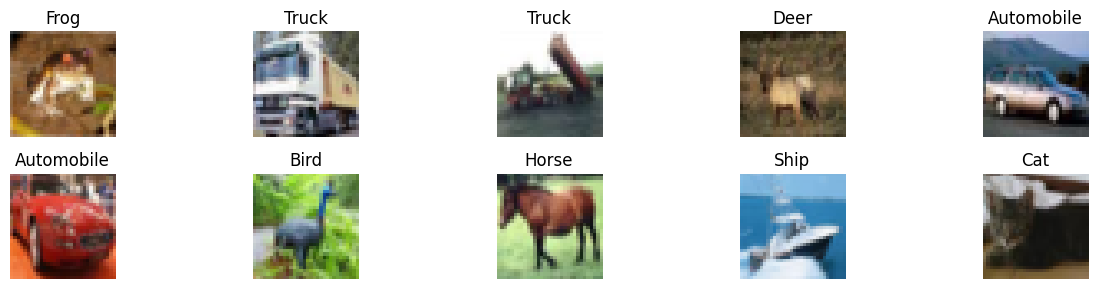

In [7]:
# Visualize sample images
plt.figure(figsize=(13, 3))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Split training data into train and validation
val_split = 0.2
val_size = int(len(train_images) * val_split)

val_images = train_images[:val_size]
val_labels = train_labels[:val_size]
train_images = train_images[val_size:]
train_labels = train_labels[val_size:]

print(f"After split:\n")
print(f"Training: {train_images.shape}")
print(f"Validation: {val_images.shape}")
print(f"Test: {test_images.shape}")

After split:

Training: (40000, 32, 32, 3)
Validation: (10000, 32, 32, 3)
Test: (10000, 32, 32, 3)


In [9]:
# Create TensorFlow datasets
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

2025-12-05 22:49:37.162004: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-05 22:49:37.162369: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-05 22:49:37.162374: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1764992977.162572  930043 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1764992977.163390  930043 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Define the Distiller Class

Custom Keras model that implements knowledge distillation.

In [10]:
# Custom model for knowledge distillation

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn,
                distillation_loss_fn, alpha, temperature):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        
        # Teacher predictions (frozen)
        teacher_predictions = self.teacher(x, training=False)
        
        with tf.GradientTape() as tape:
            # Student predictions
            student_predictions = self.student(x, training=True)
            
            # Hard loss (student vs true labels)
            student_loss = self.student_loss_fn(y, student_predictions)
            
            # Soft loss (student vs teacher)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1)
            )
            
            # Combined loss
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        # Update student weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        
        results = {m.name: m.result() for m in self.metrics}
        results.update({
            "student_loss": student_loss, 
            "distillation_loss": distillation_loss
        })
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## Define Model Architectures

Teacher: Larger CNN with dropout regularization  
Student: Smaller CNN without dropout

In [11]:
# Create teacher model - larger CNN with regularization
def create_teacher_model():
    model = keras.Sequential([
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.2),
        
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.3),
        
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.4),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10)  # 10 classes, no activation (logits)
    ], name='teacher')
    return model

In [12]:
# Create student model - smaller CNN without dropout
def create_student_model():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10)  # 10 classes, no activation (logits)
    ], name='student')
    return model

In [13]:
# Create models
teacher = create_teacher_model()
student = create_student_model()
student_scratch = create_student_model()

/Users/akshajnevgi/miniforge3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
teacher.summary()

Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249,994 (12.40 MB)

 Trainable params: 3,249,098 (12.39 MB)

 Non-trainable params: 896 (3.50 KB)

In [16]:
student.summary()

Model: "student"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compare model sizes
def count_params(model):
    return sum([np.prod(v.shape) for v in model.trainable_weights])

teacher_params = count_params(teacher)
student_params = count_params(student)

print(f"Teacher parameters: {teacher_params:,}")
print(f"Student parameters: {student_params:,}")
print(f"\nCompression ratio: {teacher_params / student_params:.2f}x")
print(f"Student is {100 * (1 - student_params/teacher_params):.1f}% smaller")

Teacher parameters: 3,249,098
Student parameters: 545,098

Compression ratio: 5.96x
Student is 83.2% smaller


## Train Teacher Model

First, we train the teacher model to high accuracy.

In [18]:
# Compile teacher
teacher.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train teacher
print("Training Teacher Model...\n")
teacher_history = teacher.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training Teacher Model...

Epoch 1/20


2025-12-05 22:54:35.105740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 62ms/step - accuracy: 0.2049 - loss: 24.9155 - val_accuracy: 0.3841 - val_loss: 7.5454 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.3594 - loss: 9.5577 - val_accuracy: 0.3842 - val_loss: 6.2333 - learning_rate: 0.0010
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.4278 - loss: 4.3811 - val_accuracy: 0.5353 - val_loss: 2.1393 - learning_rate: 0.0010
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.4817 - loss: 3.7963 - val_accuracy: 0.5600 - val_loss: 2.9044 - learning_rate: 0.0010
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.5016 - loss: 4.8450 - val_accuracy: 0.5574 - val_loss: 5.3306 - learning_rate: 0.0010
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5324 - loss: 5.4336 - val_accuracy: 0.5487 - val_loss: 4.1648 - learning_rate: 0.0010
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.5975 - loss: 3.662

In [19]:
# Evaluate teacher on test set
teacher_test_loss, teacher_test_acc = teacher.evaluate(test_dataset, verbose=0)
print(f"Teacher Test Accuracy: {teacher_test_acc*100:.2f}%")

Teacher Test Accuracy: 78.64%


## Train Student with Knowledge Distillation

In [21]:
# Create distiller
distiller = Distiller(student=student, teacher=teacher)

# Compile distiller
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,  # Weight for hard loss
    temperature=5  # Temperature for softening probabilities
)

# Train with distillation
print("Training Student with Knowledge Distillation...\n")
distiller_history = distiller.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1
)

Training Student with Knowledge Distillation...

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.6661 - distillation_loss: 0.3720 - loss: 0.2333 - student_loss: 1.7787 - val_loss: 1.0565 - val_student_loss: 4.1219
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6586 - distillation_loss: 0.3813 - loss: 1.5021 - student_loss: 1.9126 - val_loss: 4.2249 - val_student_loss: 2.7264
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.6483 - distillation_loss: 0.4106 - loss: 5.1173 - student_loss: 2.0933 - val_loss: -0.6188 - val_student_loss: 5.2558
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6369 - distillation_loss: 0.4402 - loss: 14.1311 - student_loss: 2.3172 - val_loss: 23.0720 - val_student_loss: 4.9256
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.6328 - distillation_loss: 0.4969 - loss: 25.3499 - student_loss: 2.6891 - val_loss: 47.6029 - val_student_loss: 8.5216
Epoch 6/15
625/625 ━━

In [23]:
# Evaluate distilled student
results = distiller.evaluate(test_dataset, verbose=0)
distiller_test_acc = results[1]['accuracy'].numpy()
print(f"Distilled Student Test Accuracy: {distiller_test_acc*100:.2f}%")

Distilled Student Test Accuracy: 46.76%


## Train Student from Scratch (Baseline)

In [25]:
# Compile student scratch
student_scratch.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train from scratch
print("Training Student from Scratch (Baseline)...\n")
student_scratch_history = student_scratch.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    verbose=1
)

Training Student from Scratch (Baseline)...

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5464 - loss: 1.2959 - val_accuracy: 0.5898 - val_loss: 1.1385
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6212 - loss: 1.0786 - val_accuracy: 0.6395 - val_loss: 1.0397
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6578 - loss: 0.9884 - val_accuracy: 0.6403 - val_loss: 1.0272
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6704 - loss: 0.9678 - val_accuracy: 0.6377 - val_loss: 1.0875
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6607 - loss: 1.0650 - val_accuracy: 0.6027 - val_loss: 1.4703
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6270 - loss: 1.3828 - val_accuracy: 0.6109 - val_loss: 1.5537
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6095 - loss: 1.8557 - val_accuracy: 0.4954 - val_loss: 4.2805
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16m

In [26]:
# Evaluate baseline student
scratch_test_loss, scratch_test_acc = student_scratch.evaluate(test_dataset, verbose=0)
print(f"Baseline Student Test Accuracy: {scratch_test_acc*100:.2f}%")

Baseline Student Test Accuracy: 36.87%


## Comprehensive Comparison and Visualization

In [31]:
# Summary comparison

print(f"Teacher Test Accuracy:            {teacher_test_acc*100:.2f}%")
print(f"Student (Distilled) Test Accuracy: {distiller_test_acc*100:.2f}%")
print(f"Student (Scratch) Test Accuracy:   {scratch_test_acc*100:.2f}%")
print(f"\nImprovement from distillation: {(distiller_test_acc - scratch_test_acc)*100:.2f}%")
print(f"Gap from teacher: {(teacher_test_acc - distiller_test_acc)*100:.2f}%")

Teacher Test Accuracy:            78.64%
Student (Distilled) Test Accuracy: 46.76%
Student (Scratch) Test Accuracy:   36.87%

Improvement from distillation: 9.89%
Gap from teacher: 31.88%


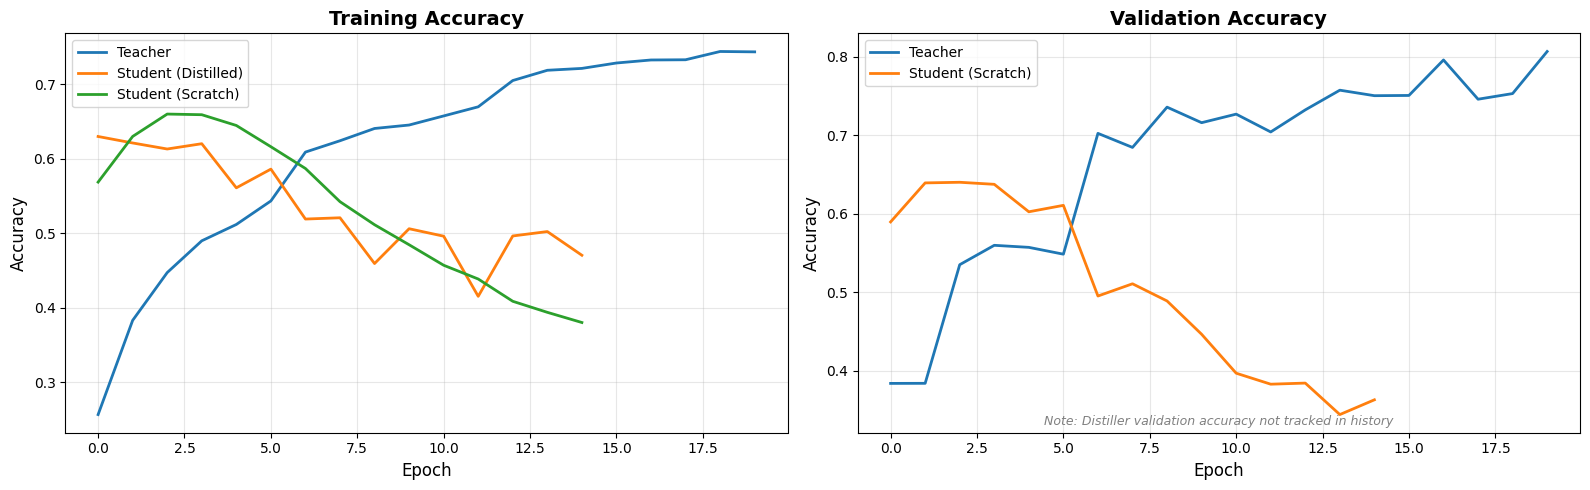

In [34]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training accuracy
axes[0].plot(teacher_history.history['accuracy'], label='Teacher', linewidth=2)
axes[0].plot(distiller_history.history['accuracy'], label='Student (Distilled)', linewidth=2)
axes[0].plot(student_scratch_history.history['accuracy'], label='Student (Scratch)', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Validation accuracy
axes[1].plot(teacher_history.history['val_accuracy'], label='Teacher', linewidth=2)
axes[1].plot(student_scratch_history.history['val_accuracy'], label='Student (Scratch)', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].text(0.5, 0.02, 'Note: Distiller validation accuracy not tracked in history', 
             transform=axes[1].transAxes, ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.show()

## Confusion Matrices

In [35]:
# Get predictions
def get_predictions(model, dataset):
    predictions = []
    labels = []
    
    for images, true_labels in dataset:
        preds = model(images, training=False)
        predictions.append(tf.argmax(preds, axis=1).numpy())
        labels.append(true_labels.numpy().flatten())
    
    return np.concatenate(predictions), np.concatenate(labels)

# Get predictions for all models
teacher_preds, true_labels = get_predictions(teacher, test_dataset)
distiller_preds, _ = get_predictions(distiller.student, test_dataset)
scratch_preds, _ = get_predictions(student_scratch, test_dataset)

2025-12-05 23:58:57.865775: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-05 23:58:58.625108: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


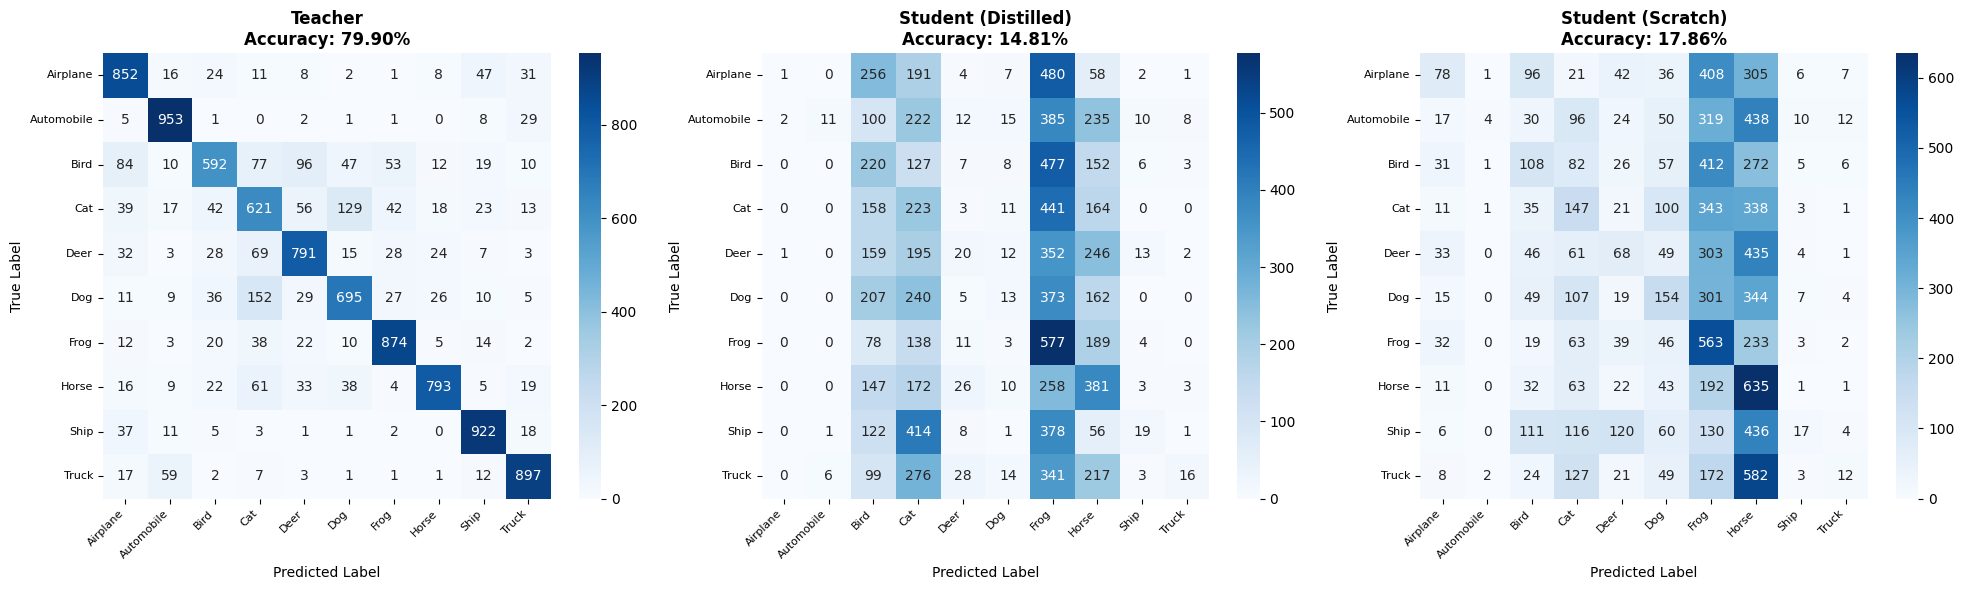

In [36]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [
    ('Teacher', teacher_preds),
    ('Student (Distilled)', distiller_preds),
    ('Student (Scratch)', scratch_preds)
]

for ax, (name, preds) in zip(axes, models):
    cm = confusion_matrix(true_labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'{name}\nAccuracy: {100*np.sum(preds==true_labels)/len(true_labels):.2f}%',
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

## Per-Class Performance Analysis

In [38]:
# Calculate per-class accuracy
def per_class_accuracy(y_true, y_pred, num_classes=10):
    accuracies = []
    for i in range(num_classes):
        mask = y_true == i
        if np.sum(mask) > 0:
            acc = np.sum((y_pred[mask] == y_true[mask])) / np.sum(mask)
            accuracies.append(acc)
        else:
            accuracies.append(0)
    return accuracies

teacher_class_acc = per_class_accuracy(true_labels, teacher_preds)
distiller_class_acc = per_class_accuracy(true_labels, distiller_preds)
scratch_class_acc = per_class_accuracy(true_labels, scratch_preds)

# Create DataFrame
class_acc_df = pd.DataFrame({
    'Class': class_names,
    'Teacher': teacher_class_acc,
    'Distilled': distiller_class_acc,
    'Scratch': scratch_class_acc
})

print("\nPer-Class Accuracy:")
print(class_acc_df.to_string(index=False))


Per-Class Accuracy:
     Class  Teacher  Distilled  Scratch
  Airplane    0.852      0.001    0.078
Automobile    0.953      0.011    0.004
      Bird    0.592      0.220    0.108
       Cat    0.621      0.223    0.147
      Deer    0.791      0.020    0.068
       Dog    0.695      0.013    0.154
      Frog    0.874      0.577    0.563
     Horse    0.793      0.381    0.635
      Ship    0.922      0.019    0.017
     Truck    0.897      0.016    0.012


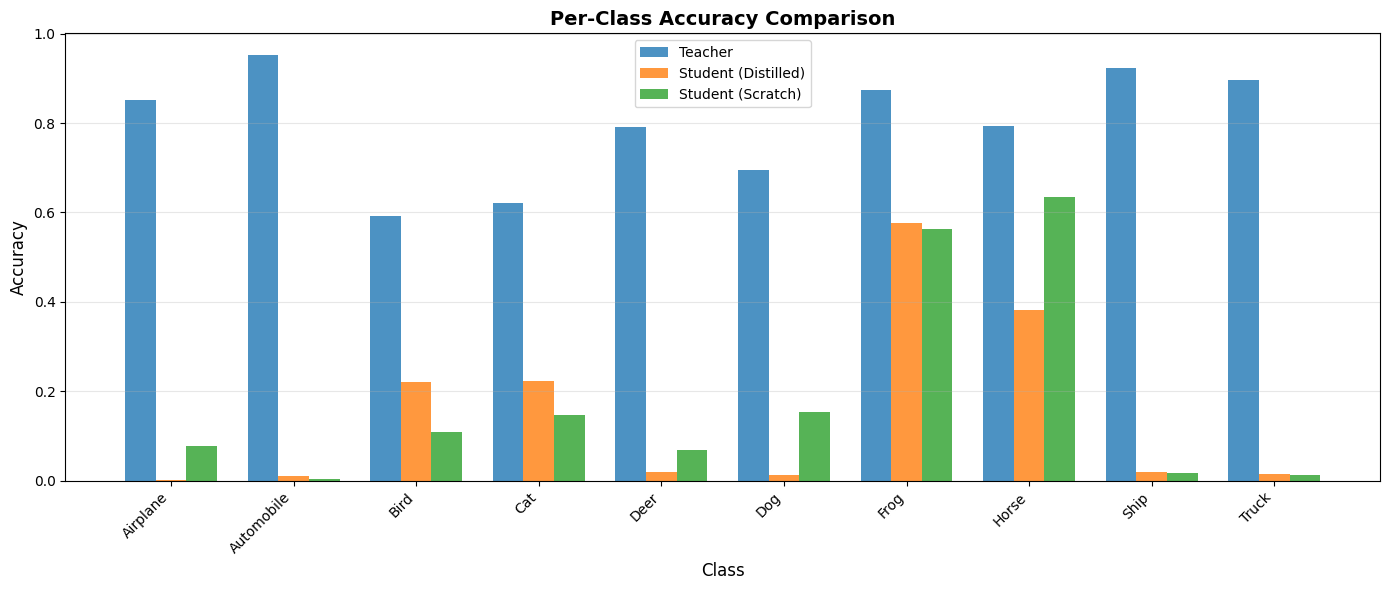

In [39]:
# Visualize per-class accuracy
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, teacher_class_acc, width, label='Teacher', alpha=0.8)
ax.bar(x, distiller_class_acc, width, label='Student (Distilled)', alpha=0.8)
ax.bar(x + width, scratch_class_acc, width, label='Student (Scratch)', alpha=0.8)

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Save Models

In [42]:
# Save trained models
teacher.save('teacher_model.h5')
distiller.student.save('student_distilled.h5')
student_scratch.save('student_scratch.h5')

print("Models saved successfully!")

Models saved successfully!


I have successfully implemented knowledge distillation on CIFAR-10 with comprehensive analysis and visualizations.